In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import itertools
import env
import wrangle as wra

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler


In [2]:
grocery_query = """select *
                from grocery_customers"""

url = env.get_db_url('grocery_db')
    
df = pd.read_sql(grocery_query, url, index_col="customer_id")

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df = df.rename(columns={'detergents_paper': 'detergents', 'delicassen': 'deli'})

In [6]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents,deli
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [7]:
# Step:1 variables to cluster
fdd_df = df[['frozen', 'detergents', 'deli']]
fdd_df.head()

,frozen,detergents,deli
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [9]:
# Step: 2 Convert to array & dtype float
fdd_df.iloc[0]

frozen         214
detergents    2674
deli          1338
Name: 0, dtype: int64

In [10]:
fdd_df.values.astype("float32", copy=False)[0]

array([ 214., 2674., 1338.], dtype=float32)

In [11]:
np_array = fdd_df.values.astype("float32", copy=False)

In [12]:
# scale to standard normal

# MAKE the scaler
mms = MinMaxScaler()

# FIT/transform the scaler
fdd_scaled = mms.fit_transform(np_array)

fdd_scaled

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605233, 0.16355862],
       ...,
       [0.00677142, 0.36346266, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]], dtype=float32)

In [13]:
fdd_df.columns

Index(['frozen', 'detergents', 'deli'], dtype='object')

In [15]:
["scaled_"+column for column in fdd_df.columns]

['scaled_frozen', 'scaled_detergents', 'scaled_deli']

In [16]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["scaled_"+column for column in fdd_df.columns]

In [17]:
# Save a copy of the original dataframe
original_df = df.copy()

In [18]:
# Create a dataframe containing the scaled array of values
scaled_df = pd.DataFrame(fdd_scaled, columns=scaled_columns)

In [19]:
scaled_df.sample(5)

,scaled_frozen,scaled_detergents,scaled_deli
175,0.000444,0.102709,0.035336
16,0.001791,0.110352,0.022466
232,0.010075,0.006883,0.017334
353,0.003336,0.212596,0.023112
422,0.013231,0.023148,0.025344


In [20]:
df.merge(scaled_df, on=df.index)

,key_0,channel,region,fresh,milk,grocery,frozen,detergents,deli,scaled_frozen,scaled_detergents,scaled_deli
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093
...,...,...,...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204,0.215469,0.004385,0.045912
436,436,1,3,39228,1431,764,4510,93,2346,0.073713,0.002205,0.048874
437,437,2,3,14531,15488,30243,437,14841,1867,0.006771,0.363463,0.038882
438,438,1,3,10290,1981,2232,1038,168,2125,0.016649,0.004042,0.044264


In [21]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [22]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents,deli,scaled_frozen,scaled_detergents,scaled_deli
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [24]:
# Step 4: Create DBSCAN object and fit

# Make the object
dbsc = DBSCAN(eps = .1, min_samples=20)

# Fit the object
dbsc.fit(fdd_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [25]:
# Extract labels

dbsc.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [32]:
# Step 6: Add labels back to original frame

# Assign the cluster labels
df['fdd_labels'] = dbsc.labels_

In [33]:
#see what this dataframe looks like
df.sample(5)

,channel,region,fresh,milk,grocery,frozen,detergents,deli,scaled_frozen,scaled_detergents,scaled_deli,gmf_labels,dff_labels,fdd_labels
126,1,3,19219,1840,1658,8195,349,483,0.134278,0.008475,0.010013,0,0,0
248,1,1,15671,5279,2406,559,562,572,0.008777,0.013693,0.011869,0,0,0
279,2,3,17360,6200,9694,1293,3620,1721,0.020840,0.088600,0.035836,0,0,0
5,2,3,9413,8259,5126,666,1795,1451,0.010535,0.043896,0.030204,0,0,0
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847,0,0,0


In [34]:
# Step 7: Explore

#let's see what labels holds
df.fdd_labels.value_counts()

 0    423
-1     17
Name: fdd_labels, dtype: int64

In [35]:
for combination in itertools.combinations(fdd_df.columns,2):
    print(combination)

('frozen', 'detergents')
('frozen', 'deli')
('detergents', 'deli')


In [36]:
combination[0]

'detergents'

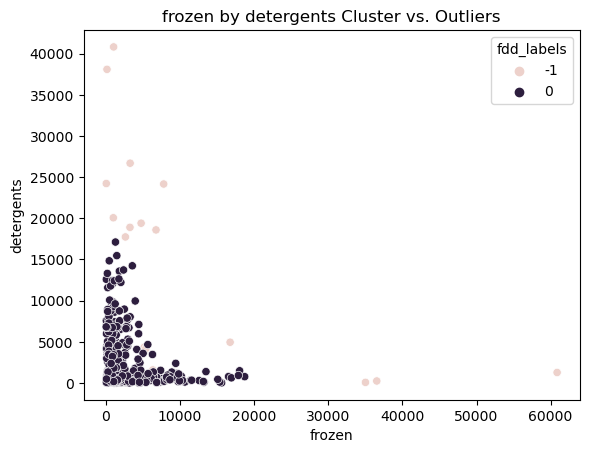

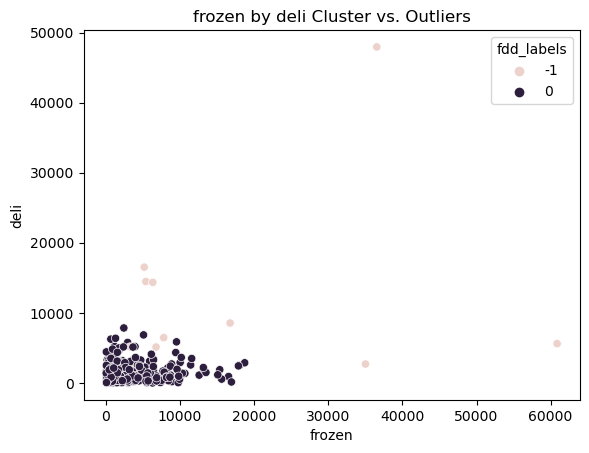

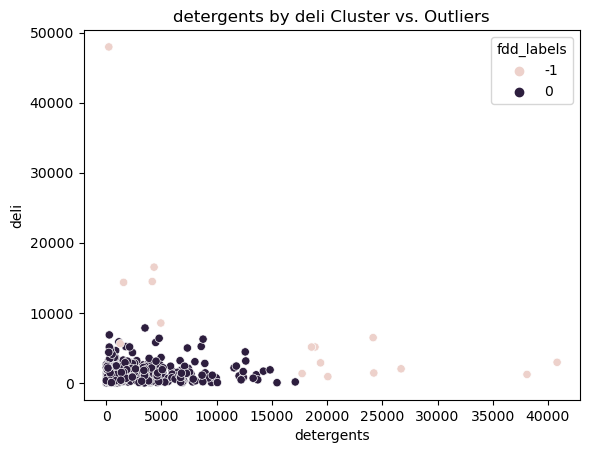

In [37]:
for combination in itertools.combinations(fdd_df.columns,2):
    sns.scatterplot(df[combination[0]], df[combination[1]], hue=df.fdd_labels)
    plt.title(f"{combination[0]} by {combination[1]} Cluster vs. Outliers")
    plt.show()

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

### Number 2 is bonus

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''

In [4]:
# call sql query, url, into a dataframe
df = pd.read_sql(query, url)

In [38]:
curriculum_query = """SELECT date,
                   path as endpoint,
                   user_id,
                   cohort_id,
                   ip as source_ip
                    FROM logs"""

url = env.get_db_url('curriculum_logs')
    
cdf = pd.read_sql(curriculum_query, url)

In [39]:
cdf.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [40]:
# change date to type datetime
cdf.date = cdf.date.astype('datetime64')

In [41]:
# set the index of the date
cdf = cdf.set_index('date')

In [42]:
# sort the index
cdf = cdf.sort_index()

### Number 2 is bonus

### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering evaluation exercises (single unit properties with a logerror).

In [2]:
# build query and look at data
zillow_query = """
        select *
        from properties_2017
        left join predictions_2017 using (parcelid)
        left join airconditioningtype using (airconditioningtypeid)
        left join architecturalstyletype using (architecturalstyletypeid)
        left join buildingclasstype using (buildingclasstypeid)
        left join heatingorsystemtype using (heatingorsystemtypeid)
        left join propertylandusetype using (propertylandusetypeid)
        left join storytype using (storytypeid)
        left join typeconstructiontype using (typeconstructiontypeid)
            where YEAR(transactiondate) = 2017;
        """

df = wra.get_zillow_data(zillow_query)

df.head()###

,Unnamed: 0,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,...,0,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,...,1,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,...,2,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,...,3,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,1970746,...,4,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
zdf = wra.wrangle_zillow(df)

In [4]:
zdf.head()

,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,261.0,24.0,14297519,1727539,3.5,4.0,3.5,3100.0,3100.0,6059.0,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0,0.025595,2017-01-01,Yes,Single Family Residential
1,261.0,24.0,17052889,1387261,1.0,2.0,1.0,1465.0,1465.0,6111.0,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,1,0.055619,2017-01-01,Yes,Single Family Residential
2,261.0,24.0,14186244,11677,2.0,3.0,2.0,1243.0,1243.0,6059.0,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2,0.005383,2017-01-01,Yes,Single Family Residential
3,261.0,2.0,12177905,2288172,3.0,4.0,3.0,2376.0,2376.0,6037.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,-0.103410,2017-01-01,Central,Single Family Residential
4,266.0,2.0,10887214,1970746,3.0,3.0,3.0,1312.0,1312.0,6037.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,4,0.006940,2017-01-01,Central,Condominium


In [5]:
zdf.set_index('id', inplace=True)

In [6]:
zdf.head()

,propertylandusetypeid,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
id,,,,,,,,,,,,,,,,,,,,,
1727539,261.0,24.0,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0,0.025595,2017-01-01,Yes,Single Family Residential
1387261,261.0,24.0,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,1,0.055619,2017-01-01,Yes,Single Family Residential
11677,261.0,24.0,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2,0.005383,2017-01-01,Yes,Single Family Residential
2288172,261.0,2.0,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,-0.103410,2017-01-01,Central,Single Family Residential
1970746,266.0,2.0,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,4,0.006940,2017-01-01,Central,Condominium


In [7]:
# Step 1: Select variables you want to cluster 'bedroomcnt' and 'calculatedfinishedsquarefeet'
bedroom_sf = zdf[['bedroomcnt', 'calculatedfinishedsquarefeet']]
bedroom_sf.head()

,bedroomcnt,calculatedfinishedsquarefeet
id,,
1727539,4.0,3100.0
1387261,2.0,1465.0
11677,3.0,1243.0
2288172,4.0,2376.0
1970746,3.0,1312.0


In [8]:
bedroom_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69447 entries, 1727539 to 1187175
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    69447 non-null  float64
 1   calculatedfinishedsquarefeet  69447 non-null  float64
dtypes: float64(2)
memory usage: 1.6 MB


In [9]:
bedroom_sf.iloc[0]

bedroomcnt                         4.0
calculatedfinishedsquarefeet    3100.0
Name: 1727539, dtype: float64

In [10]:
bedroom_sf.values.astype("float32", copy=False)[0]

array([   4., 3100.], dtype=float32)

In [11]:
#convert to an array and turn into float
np_array = bedroom_sf.values.astype("float32", copy=False)

In [ ]:
# Step 3: Scale to standard normal

